# (Title to be decided)

*This is the file for the code of our group assignment. Under development.*

In [200]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## 1. Read Data from External File

Read data in external files. For convenience, the original `.pcapng` file has been converted into `.json` and `.csv` with Wireshark.

In [201]:
# Read the JSON including all details of packets
#   errors="surrogateescape" to pass the encoding errors raised by contents in HTTP packets
with open("./data/traffic.json", "r", encoding="utf-8", errors="surrogateescape") as f:
    dataset_json=json.load(f)
    print(f"{len(dataset_json)} packets read")

# print one for checking
dataset_json[0]

10625 packets read


{'_index': 'packets-XXXX-XX-XX',
 '_type': 'doc',
 '_score': None,
 '_source': {'layers': {'pkt_comment': {'frame.comment': '13682128230572000042,china',
    'frame.comment_tree': {'_ws.expert': {'frame.comment.expert': '',
      '_ws.expert.message': '13682128230572000042,china',
      '_ws.expert.severity': '1048576',
      '_ws.expert.group': '184549376'}}},
   'frame': {'frame.interface_id': '0',
    'frame.interface_id_tree': {'frame.interface_name': 'unknown'},
    'frame.encap_type': '7',
    'frame.time': 'Not representable',
    'frame.offset_shift': '0.000000000',
    'frame.time_epoch': '-1460980371.753735000',
    'frame.time_delta': '0.000000000',
    'frame.time_delta_displayed': '0.000000000',
    'frame.time_relative': '0.000000000',
    'frame.number': '1',
    'frame.len': '58',
    'frame.cap_len': '58',
    'frame.marked': '0',
    'frame.ignored': '0',
    'frame.protocols': 'raw:ip:udp:dns',
    'frame.coloring_rule.name': 'UDP',
    'frame.coloring_rule.string': 

In [202]:
# # TODO: UNUSED - REMOVE LATER
# # Read the CSV
# # TODO: Info in CSV should be covered by the one in JSON.
# #       Remove it in the future if not used
# dataset_csv=pd.read_csv("./data/traffic.csv")

# dataset_csv

## 2. Data Preprocessing

### 2.1 Extract dataset labels

In [203]:
# Extract labels(y) from JSON
dataset_y = np.array(list(map(
    lambda packet_json: (packet_json["_source"]["layers"]["pkt_comment"]["frame.comment"]).split(",")[1], 
    dataset_json
)))

print(f"Labels include {np.unique(dataset_y)}")
print(dataset_y.shape)

Labels include ['china' 'india' 'us']
(10625,)


### 2.2 Extract features

In [204]:
# Extract source IP, source IP host, destination IP and destination IP host from dataset
dataset_X_ip_src = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src"], 
    dataset_json
)))
dataset_X_ip_src_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src_host"], 
    dataset_json
)))
dataset_X_ip_dst = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst"], 
    dataset_json
)))
dataset_X_ip_dst_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst_host"], 
    dataset_json
)))

# print first ones for checking
print(dataset_X_ip_src[0])
print(dataset_X_ip_src_host[0])
print(dataset_X_ip_dst[0])
print(dataset_X_ip_dst_host[0])


10.11.1.3
10.11.1.3
8.8.8.8
dns.google


### 2.3 Check data sanity and deal with missing fields

In [205]:
# Data sanity check
pattern_not_ipv4 = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}))")
pattern_not_ipv4_nor_domain = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3})|[-_0-9a-zA-Z]+\.[-_0-9a-zA-Z]+)")

print("Source/dest IP not an IPv4 address:")
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_src)))
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_dst)))
print("Source/dest host not an IPv4 nor a domain:")
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_src_host)))
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_dst_host)))

print()

# Fill the missing `dst.host`
#
# Find "no-data" rows
missing_dst_host_indexes = np.where(dataset_X_ip_dst_host=='no-data')[0]
print(f"Indexes of rows with missing 'dst.host': {missing_dst_host_indexes}")

# Fill the field with the IP address in `dst`, following the way of other rows
for i in missing_dst_host_indexes:
    dataset_X_ip_dst_host[i] = dataset_X_ip_dst[i]

print("Missing 'dst.host' filled")

Source/dest IP not an IPv4 address:
[]
[]
Source/dest host not an IPv4 nor a domain:
[]
['no-data', 'no-data']

Indexes of rows with missing 'dst.host': [960 964]
Missing 'dst.host' filled


### 2.4 Bi-gram for similarity between IPs and domains

In [206]:
# bi-gram for similar IP and hostnames
bigram_vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r"(?u)[^.]+")
dataset_X_ip_src_bg = bigram_vec.fit_transform(dataset_X_ip_src).toarray()
dataset_X_ip_src_host_bg = bigram_vec.fit_transform(dataset_X_ip_src_host).toarray()
dataset_X_ip_dst_bg = bigram_vec.fit_transform(dataset_X_ip_dst).toarray()
dataset_X_ip_dst_host_bg = bigram_vec.fit_transform(dataset_X_ip_dst_host).toarray()

print(dataset_X_ip_src_bg.shape)
print(dataset_X_ip_src_host_bg.shape)
print(dataset_X_ip_dst_bg.shape)
print(dataset_X_ip_dst_host_bg.shape)

dataset_X = np.concatenate((
    dataset_X_ip_src_bg, 
    dataset_X_ip_src_host_bg,
    dataset_X_ip_dst_bg, 
    dataset_X_ip_dst_host_bg), axis=1)

print("")
print(dataset_X.shape)


(10625, 1402)
(10625, 867)
(10625, 1629)
(10625, 1059)

(10625, 4957)


### 2.5 Normalization

In [207]:
# Normalization
dataset_X = MinMaxScaler().fit_transform(dataset_X)
print(dataset_X.shape)

(10625, 4957)


### 2.6 Principal Component Analysis (PCA)

In [208]:
# # PCA - check the 95% with figure
# pca = PCA()
# pca.fit(dataset_X)
# pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

# plt.figure()
# plt.axis([0, dataset_X.shape[1], 0, 1]) 
# plt.plot(pca_cumsum)
# plt.axhline(y=0.95,color='red')
# plt.xlabel("dimensions")
# plt.ylabel("explained variance")
# plt.grid(True)
# plt.show()

In [209]:
# Apply PCA for compression
pca = PCA(n_components=0.95)
dataset_X = pca.fit_transform(dataset_X)

print(dataset_X.shape)

(10625, 650)


### 2.7 Dataset split

In [210]:
# Split the dataset into training set and testing set
train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, random_state=12345)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
train_X

(7968, 650)
(7968,)
(2657, 650)
(2657,)


array([[-1.08502832e+00,  1.35391675e+00, -8.98510724e-02, ...,
         1.61431542e-05, -3.24287461e-03, -4.02308876e-05],
       [-1.37256606e+00, -1.30645738e+00, -2.43504060e-03, ...,
         1.47518527e-05,  6.61440472e-03, -2.26175618e-04],
       [-1.44957648e+00, -1.28237230e+00, -1.15245375e-02, ...,
         9.79593372e-06,  7.32780186e-04, -1.83503984e-05],
       ...,
       [-1.35841130e+00, -1.32739694e+00, -2.06831953e-04, ...,
         3.10242880e-06, -2.13589786e-02, -3.19577991e-05],
       [ 1.52944088e+00, -2.97314827e-02,  1.42330582e+00, ...,
         4.08650518e-03,  6.30412056e-06,  2.91432256e-03],
       [ 1.81760780e+00, -1.45667155e-01, -1.16834515e+00, ...,
         3.43173962e-03,  3.24887331e-06,  1.48616571e-03]])

### 2.X kNN classification as an example for using the processed dataset

(And for checking the preprocess performance at the early stage)

TODO: REMOVE BEFORE FINAL SUBMIT

In [211]:
# kNN classification test
#
# TODO: A brief test for evaluating performance during writing preprocessin code, 
#       gonna be removed later
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X, train_y)
print(f"Accuracy on test set: {knn.score(test_X, test_y):.4f}")

Accuracy on test set: 0.8683


## 3. Model Training

### 3.1 Logistic Regression

TODO

### 3.2 Support Vector Machine (SVM)

TODO

### 3.3 (?) neural network

Maybe?

In [212]:
from tensorflow import keras

keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[train_X.shape[1]]),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation="softmax")
])

print(model.summary())
print(model.output_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               195300    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total params: 286,503
Trainable params: 286,503
Non-trainable params: 0
_________________________________________________________________
None
(None, 3)


In [213]:
opt = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [214]:
temp_train_y = pd.DataFrame(train_y, columns=['country'])
temp_train_y = pd.factorize(temp_train_y['country'])[0]
train_X_nn, validate_X, train_y_nn, validate_y = train_test_split(train_X, temp_train_y)

train_y_nn = keras.utils.to_categorical(train_y_nn, 3).astype('int32')
validate_y = keras.utils.to_categorical(validate_y, 3).astype('int32')

print(train_X_nn.shape)
print(validate_X.shape)
print(train_y_nn.shape)
print(validate_y.shape)

(5976, 650)
(1992, 650)
(5976, 3)
(1992, 3)


In [220]:
history = model.fit(train_X_nn, train_y_nn, epochs=20,
                    validation_data=(validate_X, validate_y))

Epoch 1/20
187/187 [==============================] - 0s 2ms/step - loss: 0.3798 - accuracy: 0.8482 - val_loss: 0.3963 - val_accuracy: 0.8404
Epoch 2/20
187/187 [==============================] - 0s 2ms/step - loss: 0.3784 - accuracy: 0.8479 - val_loss: 0.3950 - val_accuracy: 0.8409
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.3769 - accuracy: 0.8499 - val_loss: 0.3937 - val_accuracy: 0.8323
Epoch 4/20
187/187 [==============================] - 0s 1ms/step - loss: 0.3755 - accuracy: 0.8482 - val_loss: 0.3924 - val_accuracy: 0.8328
Epoch 5/20
187/187 [==============================] - 0s 1ms/step - loss: 0.3741 - accuracy: 0.8506 - val_loss: 0.3911 - val_accuracy: 0.8328
Epoch 6/20
187/187 [==============================] - 0s 1ms/step - loss: 0.3727 - accuracy: 0.8516 - val_loss: 0.3897 - val_accuracy: 0.8424
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.3713 - accuracy: 0.8511 - val_loss: 0.3886 - val_accuracy: 0.8333
Epoch 

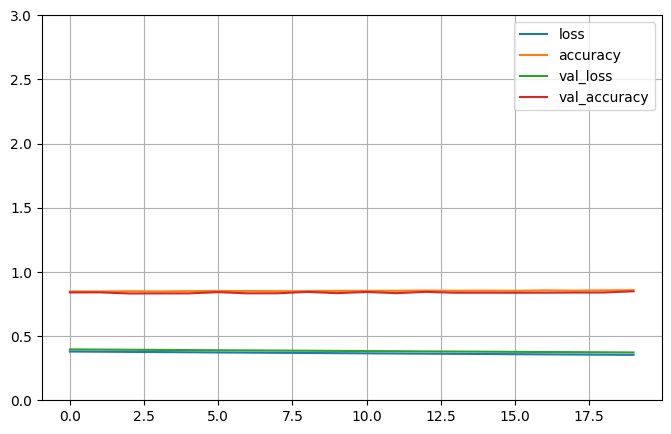

In [221]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

## 4. Model Testing and Comparison

TODO